# Ingeniería de Características y Selección Basada en Correlación

En todo proceso de modelado supervisado, la calidad de las variables de entrada puede llegar a ser tan determinante como el propio algoritmo. En este notebook proponemos una estrategia estadística para segmentar nuestro espacio de características en dos grupos: uno con las **columnas más fuertemente correlacionadas** y otro con aquellas de **correlación moderada** con respecto a la variable objetivo. De este modo, podremos entrenar modelos con distintos niveles de información y comparar directamente su desempeño.

Primero, ampliamos nuestro set original de datos generando nuevas variables —por ejemplo, interacciones o polinomios— que potencialmente capten patrones no lineales. A continuación, medimos la relevancia de cada característica mediante el coeficiente de correlación de Pearson:

$$
r_i = \frac{\mathrm{cov}(X_i, Y)}{\sigma_{X_i}\,\sigma_{Y}}
$$

y cuantificamos la redundancia usando el **Factor de Inflación de la Varianza (VIF)**:

$$
\mathrm{VIF}_i = \frac{1}{1 - R_i^2}
$$

donde \(R_i^2\) es el coeficiente de determinación al ajustar \(X_i\) como variable dependiente frente al resto de columnas del dataset.

Para decidir qué columnas pasan a cada grupo, estudiamos la **distribución empírica** de los valores \(\lvert r_i\rvert\). Definimos dos umbrales basados en percentiles:

- El **66.6 %** señala el corte para nuestra **Tabla “Relevante”** (correlaciones más altas).  
- El **33.3 %** marca el límite mínimo para la **Tabla “Semi-Relevante”** (correlaciones moderadas).

El resto de las variables, con \(\lvert r_i\rvert\) por debajo del percentil 33.3, queda fuera del conjunto de entrenamiento por aportar muy poca señal.

En la siguiente sección presentamos una visualización con una curva normal de referencia:

![Distribución de correlaciones con la variable objetivo](Graphics\Ej_filtrado_correlacion.png)

Las áreas sombreadas a la derecha de cada umbral permiten apreciar de un solo vistazo la proporción de columnas seleccionadas.

Finalmente, crearemos dos DataFrames —uno con las columnas del grupo “Relevante” y otro con las del grupo “Semi-Relevante”— y aplicaremos la **ecuación de pronóstico** proporcionada por el concurso para predecir el número de unidades vendidas en los 16 días siguientes. Evaluaremos cada modelo comparando métricas de error de regresión como **MAE** (Error Absoluto Medio) y **RMSE** (Raíz del Error Cuadrático Medio) para determinar si el uso de un conjunto de variables más amplio (Semi-Relevante) mejora o empeora las predicciones frente al conjunto más restringido (Relevante). Esta metodología aporta rigor estadístico y flexibilidad para explorar el trade-off entre complejidad del modelo y precisión de la predicción.


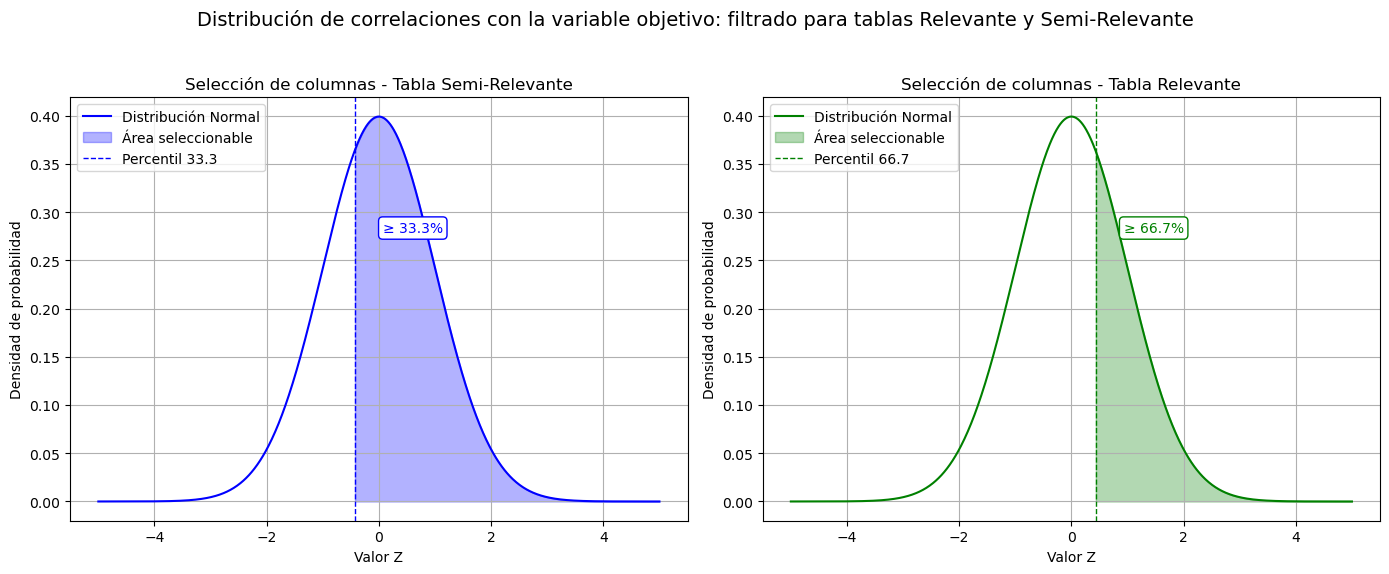

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Datos base
x = np.linspace(-5, 5, 1000)
mean = 0
std_dev = 1
y = norm.pdf(x, mean, std_dev)

# Percentiles
p33 = norm.ppf(0.333, loc=mean, scale=std_dev)
p66 = norm.ppf(0.6666666, loc=mean, scale=std_dev)

# Crear figura con dos subgráficas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Tabla Semi-Relevante
ax1.plot(x, y, color='blue', label='Distribución Normal')
ax1.fill_between(x, y, where=(x >= p33), color='blue', alpha=0.3, label='Área seleccionable')
ax1.axvline(p33, color='blue', linestyle='--', linewidth=1, label='Percentil 33.3')
ax1.text(p33 + 0.5, max(y)*0.7, '≥ 33.3%', color='blue', fontsize=10, bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3'))
ax1.set_title('Selección de columnas - Tabla Semi-Relevante', fontsize=12)
ax1.set_xlabel('Valor Z')
ax1.set_ylabel('Densidad de probabilidad')
ax1.legend(loc='upper left')
ax1.grid(True)

# Tabla Relevante
ax2.plot(x, y, color='green', label='Distribución Normal')
ax2.fill_between(x, y, where=(x >= p66), color='green', alpha=0.3, label='Área seleccionable')
ax2.axvline(p66, color='green', linestyle='--', linewidth=1, label='Percentil 66.7')
ax2.text(p66 + 0.5, max(y)*0.7, '≥ 66.7%', color='green', fontsize=10, bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))
ax2.set_title('Selección de columnas - Tabla Relevante', fontsize=12)
ax2.set_xlabel('Valor Z')
ax2.set_ylabel('Densidad de probabilidad')
ax2.legend(loc='upper left')
ax2.grid(True)

# Título general mejorado
plt.suptitle('Distribución de correlaciones con la variable objetivo: filtrado para tablas Relevante y Semi-Relevante', fontsize=14)

# Ajustar diseño
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Claro, aquí tienes una versión mejorada, más clara, coherente y profesional del texto, junto con la fórmula de variación porcentual diaria y un ejemplo más estructurado del análisis de desfase:

---

Vamos a utilizar como plantilla base la tabla `train`, a partir de la cual crearemos dos nuevas copias denominadas `Test_50_insight` y `Test_100_insight`.

Planeo trabajar con el DataFrame `oil`, del cual extraeremos las columnas `date` y `dcoilwtico` (precio del petróleo WTI). Con esta información, calcularemos la **variación porcentual diaria del precio del petróleo** y la almacenaremos en una nueva columna llamada `oil_price`.

Esta columna será posteriormente combinada con la tabla `train`, alineando los valores por la columna `date`, para así conocer cómo varió el precio del petróleo cada día específico.

### Cálculo de la variación porcentual diaria

La fórmula para calcular la variación porcentual diaria es:

$$
\text{variación}_{t} = \frac{P_{t} - P_{t-1}}{P_{t-1}} \times 100
$$

Donde:

* $P_t$ es el precio del petróleo en el día actual
* $P_{t-1}$ es el precio del día anterior

### Justificación del desfase temporal

Inicialmente se pensó en **adelantar un día** la variable `oil_price`, ya que el precio del petróleo actual podría influir en las decisiones del mercado **al día siguiente**, no en el mismo día en que se registra el precio. Sin embargo, para tomar una decisión informada, se propone realizar un análisis de **correlación** entre la variable `oil_price` y otras variables objetivo, considerando tres escenarios distintos:

1. **Desfase -1 (precio del día anterior):**
   Se utiliza el precio del petróleo del día anterior para predecir el comportamiento del día actual.
2. **Sin desfase (precio actual):**
   Se utiliza el precio del petróleo del mismo día.
3. **Desfase +1 (precio del día siguiente):**
   Se usa el precio del día siguiente, bajo la hipótesis de que el precio de hoy refleja la reacción al comportamiento del día anterior.

### Ejemplo ilustrativo de desfases

Aquí tienes un ejemplo más claro de cómo funciona el desfase en los precios del petróleo. Supongamos que los precios diarios son los siguientes:

| Fecha      | Precio WTI |
| ---------- | ---------- |
| 17 de mayo | 1.01       |
| 18 de mayo | 1.05       |
| 19 de mayo | 1.02       |

Y que nuestra plantilla `train` contiene las mismas fechas como índice para unir:

| Fecha      | … otras columnas … |
| ---------- | ------------------ |
| 17 de mayo | …                  |
| 18 de mayo | …                  |
| 19 de mayo | …                  |

Ahora veamos los tres escenarios:

---

### 1. Desfase -1 (precio del día anterior)

Aquí asignamos al 18 de mayo el precio del 17 de mayo, y al 19 de mayo el del 18 de mayo:

| Fecha (train) | oil\_price (t-1) |
| ------------- | ---------------- |
| 17 de mayo    | —                |
| 18 de mayo    | 1.01             |
| 19 de mayo    | 1.05             |

* **Interpretación**: Para el 18 usas el precio del 17, asumiendo que el mercado reacciona con un día de retraso.

---

### 2. Sin desfase (precio del mismo día)

Asignamos a cada fecha su propio precio:

| Fecha (train) | oil\_price (t) |
| ------------- | -------------- |
| 17 de mayo    | 1.01           |
| 18 de mayo    | 1.05           |
| 19 de mayo    | 1.02           |

* **Interpretación**: El modelo ve el precio del petróleo del mismo día.

---

### 3. Desfase +1 (precio del día siguiente)

Aquí adelantamos un día: al 17 de mayo le ponemos el precio del 18, y al 18 el del 19:

| Fecha (train) | oil\_price (t+1) |
| ------------- | ---------------- |
| 17 de mayo    | 1.05             |
| 18 de mayo    | 1.02             |
| 19 de mayo    | —                |

* **Interpretación**: El modelo “ve” el precio que estará disponible mañana, ideal si crees que las señales del petróleo ya anticipan movimientos un día antes.

---

Con estos tres conjuntos de datos podrás calcular el coeficiente de correlación de cada versión de `oil_price` con tu variable objetivo y decidir cuál desfase aporta más valor predictivo.


hOLIDAYS_Eents
este es otro dataframe que contiene columnas que podremos sacarle provecho pensaba en crear dos nuevas columas para nuestra base train donde las columnas se llamaran si es festivo o no de forma booleana si es true o false y la otra columna me dira el tipo de dia festivo si es regional local o nacional

In [4]:
# %%python
import yaml
import psycopg2
from psycopg2.extras import RealDictCursor
from pathlib import Path

# 0. (Opcional) verifica tu cwd para entender dónde estás
# import os
# print("CWD:", os.getcwd())

# 1. Construye la ruta absoluta al root del repo (un nivel arriba de notebooks)
project_root = Path.cwd().parent

# 2. Señala tu config.yaml dentro de config/
config_path = project_root / "config" / "config.yaml"

# 3. Carga el YAML
with config_path.open("r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)
db = cfg["database"]

# 4. Conecta a PostgreSQL y prueba
try:
    conn = psycopg2.connect(
        host=db["host"],
        port=db["port"],
        user=db["user"],
        password=db["password"],
        dbname=db["database"]
    )
    cur = conn.cursor(cursor_factory=RealDictCursor)
    cur.execute("SELECT version();")
    version = cur.fetchone()["version"]
    print(f"✅ Conexión exitosa. Versión de PostgreSQL: {version}")
except Exception as e:
    print(f"❌ Error al conectar: {e}")
finally:
    if 'conn' in locals() and conn:
        conn.close()


✅ Conexión exitosa. Versión de PostgreSQL: PostgreSQL 17.5 on x86_64-pc-linux-musl, compiled by gcc (Alpine 14.2.0) 14.2.0, 64-bit
